1-2.3 What happens when gradient is almost zero?


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, List
def make_classification_curve(n_points: int = 300) -> Tuple[torch.Tensor, torch.Tensor]:
    x = torch.linspace(-1.5, 1.5, n_points, dtype=torch.float32).unsqueeze(1)
    y_cont = torch.sinc(5 * x / np.pi)          
    y = (y_cont > 0).float()                    
    return x, y
@dataclass
class NetCfg:
    d_in: int = 1
    h1: int = 8
    h2: int = 10
    h3: int = 8
    h4: int = 4
    d_out: int = 1

class TinyMLP(nn.Module):
    def __init__(self, cfg: NetCfg = NetCfg()):
        super().__init__()
        self.l1 = nn.Linear(cfg.d_in, cfg.h1)
        self.l2 = nn.Linear(cfg.h1,   cfg.h2)
        self.l3 = nn.Linear(cfg.h2,   cfg.h3)
        self.l4 = nn.Linear(cfg.h3,   cfg.h4)
        self.out = nn.Linear(cfg.h4,  cfg.d_out)
        self.act = nn.Softplus(beta=1.3)  # smooth 2nd derivatives

    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.act(self.l3(x))
        x = self.act(self.l4(x))
        return self.out(x)  # logits for BCEWithLogitsLoss


def drive_to_critical(
    net: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epochs_fit: int = 1000,
    lr_fit: float = 2e-3,
    epochs_grad: int = 220,
    lr_grad: float = 6e-4,
    stop_grad_norm: float = 1e-4
) -> float:
    bce = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(net.parameters(), lr=lr_fit)

    
    for _ in range(epochs_fit):
        loss = bce(net(x), y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

    for g in opt.param_groups:
        g["lr"] = lr_grad

    for _ in range(epochs_grad):
        loss = bce(net(x), y)
        grads = torch.autograd.grad(loss, tuple(net.parameters()), create_graph=True)
        grad_energy = 0.5 * sum((g**2).sum() for g in grads)

        opt.zero_grad(set_to_none=True)
        grad_energy.backward()
        opt.step()

        with torch.no_grad():
            gnorm = (sum((g.detach()**2).sum() for g in grads)).sqrt().item()
            if gnorm < stop_grad_norm:
                break

    with torch.no_grad():
        final_loss = bce(net(x), y).item()
    return final_loss


def minimal_ratio_hessian(net: nn.Module, x: torch.Tensor, y: torch.Tensor,
                          jitter: float = 1e-8) -> float:
    old_dtype = next(net.parameters()).dtype
    net = net.double()
    x64, y64 = x.double(), y.double()

    params = tuple(p for p in net.parameters() if p.requires_grad)

    def loss_closure(*param_tuple):
        with torch.no_grad():
            for p, newp in zip(net.parameters(), param_tuple):
                p.copy_(newp)
        return F.binary_cross_entropy_with_logits(net(x64), y64)

    Hblocks = torch.autograd.functional.hessian(loss_closure, params)

    sizes = [p.numel() for p in params]
    N = sum(sizes)
    H = torch.zeros((N, N), dtype=torch.float64)
    r = 0
    for i, si in enumerate(sizes):
        c = 0
        for j, sj in enumerate(sizes):
            H[r:r+si, c:c+sj] = Hblocks[i][j].reshape(si, sj)
            c += sj
        r += si

    
    H.diagonal().add_(jitter)

    evals = torch.linalg.eigvalsh(H)
    
    rel = evals.abs().max().item()
    tol = max(1e-10, 1e-6 * rel)
    pos = (evals > tol).sum().item()
    mr = pos / float(N)

    net = net.to(old_dtype)
    return mr


@torch.no_grad()
def minimal_ratio_sampling(net: nn.Module, x: torch.Tensor, y: torch.Tensor,
                           sigma: float = 1e-3, trials: int = 200) -> float:
    
    vec = torch.cat([p.view(-1) for p in net.parameters()])
    D = vec.numel()
    base_loss = F.binary_cross_entropy_with_logits(net(x), y).item()
    inc = 0
    idx = 0
    for _ in range(trials):
        
        eps = torch.randn(D) * sigma
        
        start = 0
        for p in net.parameters():
            n = p.numel()
            p.add_(eps[start:start+n].view_as(p))
            start += n
       
        new_loss = F.binary_cross_entropy_with_logits(net(x), y).item()
        if new_loss > base_loss:
            inc += 1
        
        start = 0
        for p in net.parameters():
            n = p.numel()
            p.sub_(eps[start:start+n].view_as(p))
            start += n
    return inc / float(trials)


def run_trials(num_runs: int = 100, seed_base: int = 2025,
               use_fallback_when_degnerate: bool = True) -> Tuple[List[float], List[float]]:
    x, y = make_classification_curve()
    ratios, losses = [], []
    for k in range(num_runs):
        torch.manual_seed(seed_base + k)
        np.random.seed(seed_base + k)
        model = TinyMLP()
        final_loss = drive_to_critical(model, x, y)

        mr_h = minimal_ratio_hessian(model, x, y)
       
        if use_fallback_when_degnerate and (mr_h < 1e-3 or mr_h > 1 - 1e-3):
            mr_s = minimal_ratio_sampling(model, x, y, sigma=2e-3, trials=300)
            mr = mr_s
            src = "sample"
        else:
            mr = mr_h
            src = "hess"

        ratios.append(mr)
        losses.append(final_loss)
        print(f"run {k+1:03d} | mr({src})={mr:.4f}  mr_hess={mr_h:.4f}  loss={final_loss:.5f}")

    return ratios, losses





run 001 | mr(sample)=0.9767  mr_hess=1.0000  loss=0.04140
run 002 | mr(sample)=1.0000  mr_hess=1.0000  loss=0.00984
run 003 | mr(sample)=0.9933  mr_hess=1.0000  loss=0.01135
run 004 | mr(sample)=1.0000  mr_hess=1.0000  loss=0.00889
run 005 | mr(sample)=0.9500  mr_hess=1.0000  loss=0.06261
run 006 | mr(sample)=0.9833  mr_hess=1.0000  loss=0.04672
run 007 | mr(sample)=0.9733  mr_hess=1.0000  loss=0.04910
run 008 | mr(sample)=0.9900  mr_hess=1.0000  loss=0.00953
run 009 | mr(sample)=0.9800  mr_hess=1.0000  loss=0.03744
run 010 | mr(sample)=0.9700  mr_hess=1.0000  loss=0.04173
run 011 | mr(sample)=0.9933  mr_hess=1.0000  loss=0.01070
run 012 | mr(sample)=0.9967  mr_hess=1.0000  loss=0.01025
run 013 | mr(sample)=0.9400  mr_hess=1.0000  loss=0.05091
run 014 | mr(sample)=0.9900  mr_hess=1.0000  loss=0.04084
run 015 | mr(sample)=0.9600  mr_hess=1.0000  loss=0.04419
run 016 | mr(sample)=0.5933  mr_hess=1.0000  loss=0.48770
run 017 | mr(sample)=0.9967  mr_hess=1.0000  loss=0.00937
run 018 | mr(s

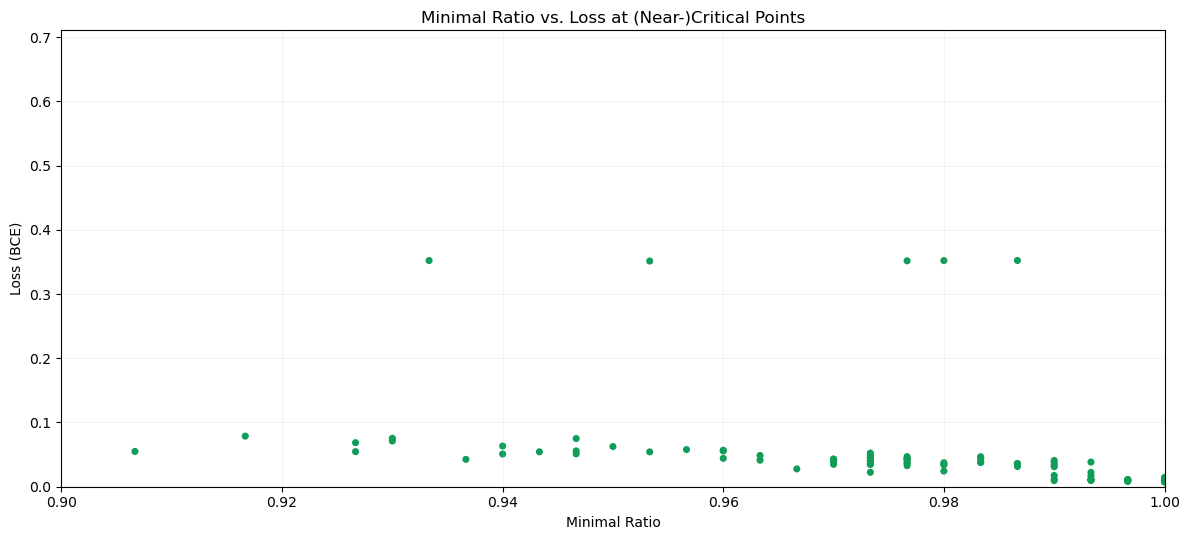

Saved: minimal_ratio_vs_loss.png


In [2]:
def scatter_plot(ratios: List[float], losses: List[float], save="minimal_ratio_vs_loss.png"):
    R = np.asarray(ratios, dtype=np.float64)
    L = np.asarray(losses, dtype=np.float64)
    plt.figure(figsize=(12, 5.5))
    plt.scatter(R, L, s=26, color="#0f9d58", edgecolors="none")
    plt.xlabel("Minimal Ratio")
    plt.ylabel("Loss (BCE)")
    plt.title("Minimal Ratio vs. Loss at (Near-)Critical Points")

    
    plt.xlim(0.90, 1.00)

    
    pad_y = 0.05 * max(1e-6, L.max())
    plt.ylim(0.0, L.max() + pad_y)

    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.savefig(save, dpi=150)
    plt.show()
    print(f"Saved: {save}")
if __name__ == "__main__":
    rs, ls = run_trials(num_runs=100)
    print(f"ratio range [{min(rs):.3f},{max(rs):.3f}]  loss range [{min(ls):.5f},{max(ls):.5f}]")
    scatter_plot(rs, ls)

